# 10-13. 프로젝트 : 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

## Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

- sunnysai12345/News_Summary (https://github.com/sunnysai12345/News_Summary)

아래의 코드로 데이터를 다운로드할 수 있어요.

In [1]:
#데이터 준비하기

import nltk  # NLTK(Natural Language Toolkit) 의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [3]:
# 랜덤한 10개 샘플 출력

data.sample(10)

,headlines,text
1758,Bus service startup Shuttl raises Ã¢ÂÂ¹10 cro...,Gurugram-based bus service startup Shuttl has ...
32701,Over 50 National Award winners boycott awards ...,Over 50 winners boycotted the 65th National Fi...
15322,Swaraj's speech at UN was aimed at BJP voters:...,Congress MP Shashi Tharoor has slammed Externa...
31819,Flipkart's journey from 2BHK apartment to $21-...,India's biggest e-commerce startup Flipkart be...
68733,Woman BJP leader booked for slapping girl in UP,An FIR has been registered against local BJP l...
13314,"Woman believes spirits haunt her, jumps in wel...",A woman jumped into a well with her five child...
69259,Woman repeatedly defecates outside family's ho...,An American family has reportedly spent seven ...
41185,Mumbai man arrested for raping 16-year-old ste...,Police have arrested a 45-year-old man for all...
22771,PepsiCo's CEO Indra Nooyi to step down after 1...,PepsiCo on Monday announced that its first fem...
38211,"Was dancer in Race 10 yrs ago, now I'm lead in...","Talking about her Bollywood journey, Daisy Sha..."


## Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요.

만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 2-1. 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
# 중복 샘플 유무 확인
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

# 데이터 고유값들의 수를 ㄹ출력해주는 함수
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


중복을 제외한다면, headlines 에는 98280개, text 에는 98,380개의 유니크한 데이터가 존재함을 확인할 수 있습니다.

In [5]:
# drop_duplicates()를 사용, 손쉽게 중복 샘플을 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다.

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
# 중복 제거후 .isnull().sum()으로 null값 유무 재확인 

print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
# 데이터 프레임에서 null 값을 제거 dropna() 함수 사용

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2-2. 텍스트 정규화와 불용어 제거

- 텍스트 정규화 : 같은 표현 통일 시키기 / 불용어 : 별도움이 되지 않음 단어

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


이제 정규화 준비까지 마쳤어요.

하지만 아직 끝난 게 아니에요. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재해요. 이를 불용어(stopwords)라고 불러요. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있어요. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 거예요.

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# 데이터 전처리 함수

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 자연스런 문장이 되기 위해 불용어들을 summary에 남겨두기
    # 불용어 제거 (Text)
    if remove_stopwords: 
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 전처리 전, 후의 결과 확인을 위한 임의 함수 호출

temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고,
과 같은 html 태그가 제거되었죠. 또한 (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있어요. 그리고 특수문자가 제거되면서 영어만 남았어요.

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행해볼게요. 이때, Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해볼게요.

❗이 코드는 시간이 오래 걸리므로 아래 멀티프로세싱 코드를 실행하는것을 추천드립니다. 우선은 코드 실행을 눌러보고, 지루해지면 코드 정지 후 넘어가주세요 :)

### 2-3. 멀티프로세싱으로 데이터 전처리
- 별도의 프로세스를 생성하여 병렬처리(소요시간 축소)

In [12]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_headlines = preprocess_data(data['headlines'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_headlines)

clean_text = preprocess_data(data['text'], remove_stopwords=False) #불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False
print(clean_text)

82.45927500724792  seconds
['upgrad learner switches career ml al salary hike'
 'delhi techie wins free food swiggy one year cred'
 'new zealand end rohit sharma led india match winning streak' ...
 'matrix film get reboot reports'
 'snoop dogg aims gun clown dressed trump new video'
 'madhesi morcha withdraws support nepalese government']
14.706498622894287  seconds
['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands li

In [13]:
# 빈(empty) 샘플 확인

data['headlines'] = clean_headlines
data['text'] = clean_text

# 빈 값을 Null 값으로 변환

data.replace('', np.nan, inplace=True)

In [14]:
# null 값 유무 재확인

data.isnull().sum()

headlines    0
text         0
dtype: int64

### 2-4. 훈련데이터와 테스트데이터 나누기

학습 진행을 위한 데이터 크기 결정 및 문장 시작, 끝 표시

#### 샘플의 최대 길이 정하기

필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 훈련에 사용할 샘플의 최대 길이를 정해줄 차례입니다.

우선 text 와 headline의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각해 보도록 하겠습니다.

text의 최소 길이 : 1
text의 최대 길이 : 69
text의 평균 길이 : 56.180195201301345
headlines의 최소 길이 : 1
headlines의 최대 길이 : 13
headlines의 평균 길이 : 7.136183407889386


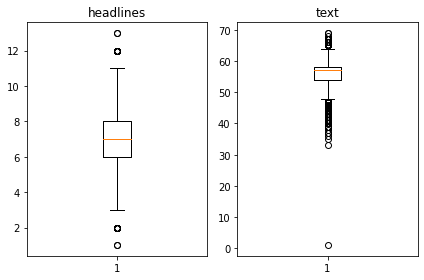

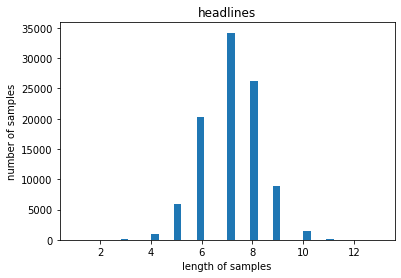

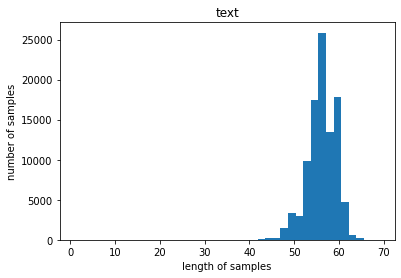

In [15]:
# 샘플의 최대 길이 분포 출력

import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text의 최소 길이 : {}'.format(np.min(text_len)))
print('text의 최대 길이 : {}'.format(np.max(text_len)))
print('text의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위에서 부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이 별 갯수, 요약본 샘플 길이 별 개수를 나타내고 있습니다.

text의 경우, 최소 길이가 2, 최대 길이가 69의 차이를 보이고, 평균 길이는 56.18로 시각화된 그래프로 보았을 땐 대체적으로 50~60 내외의 길이를 가진다는 것을 확인 할 수 있었습니다.

headlines의 경우, 최소 길이가 1, 최대 길이가 13의 차이를 보이고, 평균 길이는 7로 text에 비해서 상대적으로 길이가 매우 짧으며, 시각화 된 그래프로 보았을 떄에도 대체적으로 10 이하의 길이를 가지고 있음을 확인 할 수 있었습니다.

In [16]:
# text 의 최대 길이와 summary 의 적절한 최대 길이 임의로 정하기

text_max_len = 57
headlines_max_len = 7

In [17]:
# 훈련 데이터와 샘플의 길이를 입력하면 데이터의 몇 %가 해당하는지 계산

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 57 이하인 샘플의 비율: 0.6258235054900366
전체 샘플 중 길이가 7 이하인 샘플의 비율: 0.6264640097600651


위에서 시각화를 통해서 알아낸 평균 길이를 기반으로, text_max_len = 57, headlines_max_len = 7 로 지정을 하고, 그 이하의 샘플 비율을 조사해본 결과,

-> text 기준 57 이하인 샘플의 비율은 : 0.6258235054900366 이었으며, headlines 기준 7 이하인 샘플의 비율은 0.6264640097600651 이었습니다.

In [19]:
## 샘플들의 길이 중에서 max length 이하인 데이터들의 갯수를 알아보기

data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 39924


### 2-5. 시작 토큰과 종료 토큰 추가

In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x) #시작 토큰
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken') #종료 토큰
data.head()

,headlines,text,decoder_input,decoder_target
6,india get lowest odi total new zealand,india recorded their lowest odi total in new z...,sostoken india get lowest odi total new zealand,india get lowest odi total new zealand eostoken
12,ram krishna smoke ramdev sadhus kumbh,urging saints and seers at the kumbh mela to q...,sostoken ram krishna smoke ramdev sadhus kumbh,ram krishna smoke ramdev sadhus kumbh eostoken
18,long tolerate congress leaders potshots taka cm,days after he threatened to step down from his...,sostoken long tolerate congress leaders potsho...,long tolerate congress leaders potshots taka c...
20,think opposition even dreams pm modi,claiming there is dearth of ideas among opposi...,sostoken think opposition even dreams pm modi,think opposition even dreams pm modi eostoken
22,killed injured saudi arabia floods,at least people have been killed and others ha...,sostoken killed injured saudi arabia floods,killed injured saudi arabia floods eostoken


- 'decoder_input'의 앞에 시작 토큰인 'sostoken' 을 추가 & 'decoder_target'의 끝에는 종료 토큰인 'eostoken'을 추가

### 2-6. 훈련데이터와 테스트 데이터 분리

np.random.shuffle을 사용하여 섞인 데이터를 8:2 비율로 훈련 데이터와 테스트 데이터로 분리해 줍니다.

In [21]:
# decoder_input, decoder_target 레이블 각각 다시 numppy 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [22]:
# 훈련 데이터와 테스트 데이터 분리

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[21864 26648  6822 ...   198 37324 17239]


In [23]:
# 데이터의 샘플 순서를 정의

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
# 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 7984


In [25]:
# 테스트 데이터개수 이용해 전체 데이터 나누기

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 31940
훈련 레이블의 개수 : 31940
테스트 데이터의 개수 : 7984
테스트 레이블의 개수 : 7984


### 2-7. 단어 집합(vocabulary) 만들기 및 정수 인코딩

단어 집합 만들기 : 훈련데이터 및 테스트 데이터의 각 단어 마다 고유한 정수를 맵핑하는 작업

In [26]:
# 케라스 토크나이저 사용, 훈련 데이터로 부터 단어 집합 만들기

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어와 각 단어의 등장 빈도수가 저장
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 47951
등장 빈도가 6번 이하인 희귀 단어의 수: 33862
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 14089
단어 집합에서 희귀 단어의 비율: 70.61792246251382
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.98174181218517


In [28]:
# 기준 : 위의 단어 집합에서 6번 이하 단어를 제외시킬 경우의 단어 집합의 크기 14055

src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 정수로 잘 변경되었는지 샘플 출력
print(encoder_input_train[:3])

[[42, 8, 1, 713, 4, 1932, 7, 283, 1, 3545, 6440, 30, 5920, 6085, 152, 20, 2549, 16, 549, 3145, 3334, 1017, 3, 18, 35, 333, 4, 1, 33, 1, 1648, 686, 157, 9, 21, 11, 7523, 1, 6440, 2, 3546, 10, 15, 12, 1046, 31, 1195], [1, 54, 201, 123, 2969, 7, 80, 919, 981, 1, 1090, 3996, 6, 1, 414, 5279, 32, 80, 66, 431, 3218, 32, 284, 1, 512, 66, 431, 3, 5, 5, 1, 4579, 66, 431, 6, 370, 1, 219, 6629, 4, 1, 54, 123, 1205, 1, 80, 919, 20, 32, 66, 431, 422], [124, 5, 523, 4, 3935, 97, 11, 1266, 20, 338, 1226, 38, 1379, 59, 1, 446, 1829, 3, 658, 10, 24, 988, 251, 43, 82, 25, 254, 1906, 3, 4765, 5, 74, 7782, 2, 914, 233, 3935, 97, 39, 231, 10, 22, 709, 300, 3253, 3, 5626, 539, 1, 1829]]


In [30]:
# Summary 데이터에 동일 작업 진행, 훈련 데이터로 부터 단어 집합 만들기

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

- 단어집합 만들기 > 빈도수 낮은 단어들 훈련데이터에서 제외 > 희귀 단어 집합 크기 제외 > 정수시퀀스로 변환

In [31]:
# 빈도수가 낮은 단어들은 훈련 데이터에서 제외

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 20952
등장 빈도가 5번 이하인 희귀 단어의 수: 15102
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 5850
단어 집합에서 희귀 단어의 비율: 72.07903780068729
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 12.10443373126488


In [32]:
# 기준 : 위의 단어 집합에서 5번 이하 단어를 제외시킬 경우의 단어 집합의 크기 5885 

tar_vocab = 2000  
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 정수로 잘 변경되었는지 샘플 출력
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 911, 638, 817, 469, 22], [1, 12, 118, 82, 605, 1512], [1, 124, 886, 499, 72, 546], [1, 442, 28, 606, 91], [1, 581, 199]]
target
decoder  [[911, 638, 817, 469, 22, 2], [12, 118, 82, 605, 1512, 2], [124, 886, 499, 72, 546, 2], [442, 28, 606, 91, 2], [581, 199, 2]]


- 기준 : 위의 단어 집합에서 5번 이하 단어를 제외시킬 경우 단어 집합의 크기 5885, 학습한 LMS 노드 기준이 2000로 나와있어 그대로 적용

In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 117
삭제할 테스트 데이터의 개수 : 34
훈련 데이터의 개수 : 31823
훈련 레이블의 개수 : 31823
테스트 데이터의 개수 : 7950
테스트 레이블의 개수 : 7950


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 2-8. 패딩하기

In [34]:
# 패딩하기, 전처리 완료

encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요.
실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

### 3-1. 함수형 API를 이용해서 인코더를 설계

In [35]:
# 함수형 API를 이용해서 인코더를 설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256  # LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터(LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 3-2. 디코더 설계

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
# 디코더 출력층 설계

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 57, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 57, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 3-3. 어텐션 메커니즘

- 또 다른 신경망 생성

In [38]:
# 공개되어 있는 어텐션 함수 다운로드

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [39]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 57)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 57, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 57, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 3-4. 모델 훈련하기
- EarlyStopping(조기종료) : 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 patience=2(2회) 관측되면 학습을 멈추도록 설정

In [40]:
# 훈련 진행

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)  
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=25)

Epoch 1/25
125/125 [==============================] - 112s 811ms/step - loss: 5.1127 - val_loss: 4.4040
Epoch 2/25
125/125 [==============================] - 100s 801ms/step - loss: 4.3896 - val_loss: 4.2321
Epoch 3/25
125/125 [==============================] - 100s 804ms/step - loss: 4.2172 - val_loss: 4.0567
Epoch 4/25
125/125 [==============================] - 100s 803ms/step - loss: 4.0128 - val_loss: 3.9262
Epoch 5/25
125/125 [==============================] - 100s 801ms/step - loss: 3.8288 - val_loss: 3.7977
Epoch 6/25
125/125 [==============================] - 100s 800ms/step - loss: 3.6974 - val_loss: 3.6843
Epoch 7/25
125/125 [==============================] - 100s 801ms/step - loss: 3.5506 - val_loss: 3.5742
Epoch 8/25
125/125 [==============================] - 100s 803ms/step - loss: 3.4285 - val_loss: 3.5069
Epoch 9/25
125/125 [==============================] - 100s 803ms/step - loss: 3.3026 - val_loss: 3.4456
Epoch 10/25
125/125 [==============================] - 101s 811m

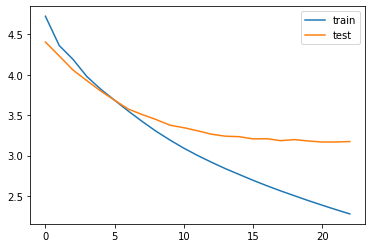

In [41]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- test에서의 loss 값이 3.5 내외에서 줄어들지 않는 문제가 생긴 것을 알 수 있습니다. (아마도 overfitting or 다른 문제로 추측
)

### 3-5. 인퍼런스 모델 구현

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 3-6. 모델 테스트

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [47]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : in safety alert email united airlines on saturday warned employees that cockpit door access information may have been made public and security codes compromised by mistake united spokesperson king said this was not hack or breach and the federal aviation administration was informed sharing sensitive information with anyone unauthorised is prohibited united staff 
실제 요약 : united airlines warns may leaked 
예측 요약 :  shut shut facebook data breach


원문 : talking about the box office success of his recent release race actor bobby deol said if was so bad it would not have worked bobby added that he is very happy that people his work and said he wants to continue doing such films the film earned crore within three days of its release 
실제 요약 : race would worked bad 
예측 요약 :  baahubali films


원문 : software engineer in hyderabad was arrested on sunday for allegedly sharing intimate pictures and videos of his girlfriend with his friends on whatsapp the man was arrested on the basis of compl

1) 옳은 예

- 원문 : 지하철 관계자에 따르면 델리 지하철에서 일하는 동안 3명이 사망하고 2명이 부상당했으며 전동차 청소 도중 전봇대에서 떨어지면서 부상당한 부상의 본질에 대해 열차에 탑승한 후 1명이 사망했다고 한다.
- 실제 요약 : 델리 지하철 근로자들이 부상당해 사망했습니다.
- 예측 요약 : 델리 지하철 화재 사망 -> 나름대로 요약이 잘 된 것 같습니다.

2) 잘못된 예

- 원문 : 대부분의 관광버스들이 뭄바이 시내버스의 교통경찰이 오전부터 자정까지 남부 뭄바이 시내버스의 진입을 명령함에 따라 화요일부터 이틀간의 파업을 위협하고 있다. 이번 파업은 주정부간 및 주정부간 버스 운행에 영향을 미칠 것으로 알려졌으며 남부 뭄바이 경찰은 버스 진입이 금지되었다고 말했다.
- 실제 요약 : 무거운 물건을 놓치는 아이들 -> 무거운 물건이나 아이들에 대한 내용이 원문에 나오지 않았으나 요약이 되는 경우가 있었습니다.


3) 잘못된 예

- 원문 : 스리랑카에서 홍수와 산사태가 발생, 실종상태로 남아 있는 가운데, 금요일 이른 계절에 전국적으로 군인들을 중심으로 한 수백명의 사람들이 경찰과 민간 기관을 돕기 위해 배와 헬리콥터로 배치되었다고 정부 관계자가 말한 후, 적어도 사망자는 있었다.
- 실제 요약 : 홍수로 스리랑카 사망
- 예측 요약 : 사이클론으로 인한 홍수 -> 홍수라는 키워드가 원문에 나오기는 하였으나 사이클론이라는 원문에 없는 단어가 나왔습니다.


- 위에서 보여준 예시 말고도 다양한 값들을 테스트 결과로 내보았으나 크게 다르지 않았습니다.
- 요약 결과 역시 의미 할 정도로 적당한 문장이 만들어지는 결과도 있었지만, 그렇지 않은 경우가 훨씬 많아 보였습니다.

## Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

### 5-1. 데이터 다운로드 하기

In [48]:
import requests
from summa.summarizer import summarize

In [49]:
data_news = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data_news["text"]

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object

In [50]:
print(data_news[:1500])

                                              headlines  \
0     upGrad learner switches to career in ML & Al w...   
1     Delhi techie wins free food from Swiggy for on...   
2     New Zealand end Rohit Sharma-led India's 12-ma...   
3     Aegon life iTerm insurance plan helps customer...   
4     Have known Hirani for yrs, what if MeToo claim...   
...                                                 ...   
1495  Have seen Sachin Tendulkar get angry but not M...   
1496  Player ensures wife stays dry in rain during A...   
1497  Federer denied entry into locker room by secur...   
1498  42/42 seats in West Bengal: CM Mamata's cutout...   
1499  Court refuses chargesheet by Delhi Police agai...   

                                                   text  
0     Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1     Kunal Shah's credit card bill payment platform...  
2     New Zealand defeated India by 8 wickets in the...  
3     With Aegon Life iTerm Insurance plan, customer...  
4

### 5-2. summarize 사용하기

- text (str) : 요약할 테스트.
- ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
- words (int or None, optional) – 출력에 포함할 단어 수.
- 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
- split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [51]:
print('Summary:')
print(summarize(data_news["text"][i], ratio=0.5))

Summary:
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


In [52]:
print('Summary:')
print(summarize(data_news["text"][i], ratio=0.5, split=True))

Summary:
['He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".']


In [53]:
print('Summary:')
print(summarize(data_news["text"][i], words=50))

Summary:
Prime Minister Narendra Modi on Wednesday said his government's demonetisation decision made houses affordable for the aspiring youth.
He added decisions like demonetisation and RERA have put a check on black money that used to be "parked in the real estate sector".


- summarize를 진행해 본 결과, 핵심이라고 생각되는 문장을 가지고 오는 듯 하였으나, 과연 일반인이 실생활에서 사용하기에 유용한가? 라는 생각을 할 정도의 결과값을 만들어 내었다고 생각합니다.

## Step 6. 루브릭 & 회고

평가기준
---
- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.
- 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.
- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

회고
---
1. 이번 프로젝트는 다루는 데이터의 양이 많아서 그런지 혹은 모델링 과정에서 저의 미숙함 때문인지 earlystoping이 있더라도 학습을 진행하는 데 많은 시간이 소요 되었던 것 같습니다.

2. 또한 영어 요약이라 한국어로 재 번역을 '파파고'를 이용해서 진행하면서 번역의 오류일 수도 있지만, 생각보다 요약이 제가 생각했었던 것 만큼 이루어지지 못해서 아쉬움이 조금 남았던 것 같습니다.

3. 아마도 추상적인 요약이 잘 되기 위해서는 하이퍼 파라미터를 조금 더 잘 조정해야 할 것이라고 추측하지만, 시간관계 상 마무리 하지 못한 것에서 아쉬움을 느꼈습니다.

4. 추가적으로 이러한 요약을 잘 하는 모델을 생성하기 위해서는 전처리 과정에서 추가적인 작업이 필요할 것이라고 추측은 하지만 정확하게 어떤 것을 추가해야할 지 몰라 이것저것 알아 보기만 하고 해결하지 못한 것에서 아쉬움을 느꼈습니다.

5. 아마도 다음 기회에 이러한 요약 모델을 할 기회가 생긴다면, 다수의 데이터를 적절하게 전처리하고 가장 최적의 학습 방법을 찾아낸 후 적합한 요약 방식을 선정해서 모델링을 진행해야 원하는 뉴스 요약이 가능할 것 같다는 생각을 할 수 있었던 프로젝트라고 생각합니다.